In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,AveragePooling2D,AveragePooling3D
from keras.layers import Dense, GlobalAveragePooling3D,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.utils import np_utils, generic_utils, Sequence
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional_recurrent import ConvLSTM2D
import keras

import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
# image specification
img_cols,img_rows=100,176
nb_frames = 16    # img_depth or number of frames used for each video
# CNN Training parameters
nb_classes = 27
channels = 2

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# integer encode
labels = pd.read_csv('E:\Jupyter\Project\jester-v1-labels.csv',sep=';',header=None,names=['Class'])     # reading the csv file
label_encoder = LabelEncoder()
labels['Label'] = label_encoder.fit_transform(labels['Class'])

#train
train = pd.read_csv('E:\Jupyter\Project\jester-v1-train.csv',sep=';',header=None,names=['Video','Class'])     # reading the csv file
train['Label'] = label_encoder.fit_transform(train['Class'])

#validation
validation = pd.read_csv('E:\Jupyter\Project\jester-v1-validation.csv',sep=';',header=None,names=['Video','Class'])     # reading the csv file
validation['Label'] = label_encoder.fit_transform(validation['Class'])

#test
#test = pd.read_csv('E:\Jupyter\Project\jester-v1-test.csv',sep=';',header=None,names=['Video'])     # reading the csv file

#print labels
#labels
"""
partition_dict = {
    "train": train["Video"].tolist(),
    "validation": validation["Video"].tolist()
}"""
temp = pd.concat([train, validation])
temp = temp.set_index("Video")
#temp = train.set_index("Video")
temp.transpose()
labels_dict = temp["Label"].to_dict()
len(train)

118562

In [23]:
#train
train = train[train["Class"].isin(["No gesture","Swiping Left","Swiping Right","Stop Sign","Rolling Hand Forward","Rolling Hand Backward"])]
train['Label'] = label_encoder.fit_transform(train['Class'])

#validation
validation = validation[validation["Class"].isin(["No gesture","Swiping Left","Swiping Right","Stop Sign","Rolling Hand Forward","Rolling Hand Backward"])]
validation['Label'] = label_encoder.fit_transform(validation['Class'])

#test
#test = pd.read_csv('E:\Jupyter\Project\jester-v1-test.csv',sep=';',header=None,names=['Video'])     # reading the csv file

#print labels
#labels
"""
partition_dict = {
    "train": train["Video"].tolist(),
    "validation": validation["Video"].tolist()
}"""
temp = pd.concat([train, validation])
temp = temp.set_index("Video")
#temp = train.set_index("Video")
temp.transpose()
labels_dict = {}
labels_dict = temp["Label"].to_dict()
len(train)

25025

In [5]:
import random
def data_gen(train_list, batch_size=64):
    while True:
        X_tr=[]
        label=[]
        for vid_ID in random.sample(train_list,batch_size):
            frames = []
            frame_count=0
            pos_dir = os.path.join("E:/Jupyter/Project/generated_images512_timeSampled/pos",str(vid_ID))
            neg_dir = os.path.join("E:/Jupyter/Project/generated_images512_timeSampled/neg",str(vid_ID))
            for img_ID in sorted(os.listdir(pos_dir)):
                if frame_count < nb_frames:
                    pos = os.path.join(pos_dir,img_ID)
                    neg = os.path.join(neg_dir,img_ID)
                    p_img = cv2.imread(pos,0)
                    p_img = cv2.resize(p_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
                    n_img = cv2.imread(neg,0)
                    n_img = cv2.resize(n_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
                    frame = cv2.merge((p_img,n_img))
                    frames.append(frame)
                    frame_count+=1
                else:
                    break
            while frame_count < nb_frames:
                frames.append(np.zeros((img_cols,img_rows,channels), np.uint8))
                frame_count+=1
            input_img = np.array(frames)
            ipt=np.rollaxis(np.rollaxis(input_img,2,0),2,0)
            ipt=np.rollaxis(ipt,2,0)
            X_tr.append(ipt)
            label.append(labels_dict[vid_ID])

        X_tr_array = np.array(X_tr)   # convert the frames read into array

        Y_train = np_utils.to_categorical(label, nb_classes)

        yield X_tr_array,Y_train

In [6]:
print(next(data_gen(train["Video"].tolist()))[0].shape)

(64, 16, 100, 176, 2)


In [7]:
#low resolution network
weight_decay = 0.005
from keras import regularizers
model = Sequential()
model.add(MaxPooling3D(pool_size=(1, 2, 2),input_shape=(nb_frames,  img_cols, img_rows, channels)))

model.add(Conv3D(8,(1,5,5),activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv3D(8,(5,1,1),activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(32,(1,5,5), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv3D(32,(3,1,1), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64,(1,3,5), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv3D(64,(3,1,1), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(1, 1, 4 )))

model.add(Flatten())
model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))

model.add(Dense(nb_classes,kernel_initializer='normal',kernel_regularizer=regularizers.l2(weight_decay)))

model.add(Activation('softmax'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling3d_1 (MaxPooling3 (None, 16, 50, 88, 2)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 16, 46, 84, 8)     408       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 12, 46, 84, 8)     328       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 12, 23, 42, 8)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 12, 19, 38, 32)    6432      
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 10, 19, 38, 32)    3104      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 5, 9, 19, 32)      0         
__________

In [9]:
import os
save_dir = os.path.join(os.getcwd(),'save_model')
print(os.getcwd())
model_name = "working"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_acc', 
                            save_best_only=True, verbose=1)
#earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose =1)

E:\Jupyter\Project


In [10]:
sgd = SGD(lr=0.003,  momentum=0.9, nesterov=False)
rms = RMSprop(decay=1e-6)
ada = Adadelta(lr=0.1,decay=1e-6)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              #optimizer=ada,
              #optimizer = Adam(lr=0.0001),
              metrics=['acc'])

In [22]:
nb_epoch = 300
batch_size=64
#steps_per_epoch=int((len(X_val_new)*1.5)/batch_size)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.05, 
                               cooldown=0, patience=10, min_lr=0.005/(2^4),verbose=1)
hist = model.fit_generator(data_gen(train["Video"].tolist()[0:],batch_size),
                           validation_data=data_gen(validation["Video"].tolist()[0:1500],batch_size),
                           steps_per_epoch=64,
                           validation_steps=8,
                           epochs = nb_epoch,
                           callbacks=[checkpoint,lr_reducer]
                          )

Epoch 1/64
 79/391 [=====>........................] - ETA: 13:51 - loss: 0.8229 - acc: 0.78 - ETA: 12:02 - loss: 0.7898 - acc: 0.79 - ETA: 11:13 - loss: 0.8415 - acc: 0.78 - ETA: 11:12 - loss: 0.8170 - acc: 0.79 - ETA: 11:06 - loss: 0.8255 - acc: 0.79 - ETA: 11:04 - loss: 0.8423 - acc: 0.78 - ETA: 11:01 - loss: 0.8317 - acc: 0.79 - ETA: 10:56 - loss: 0.8306 - acc: 0.79 - ETA: 10:59 - loss: 0.8216 - acc: 0.79 - ETA: 10:55 - loss: 0.8130 - acc: 0.80 - ETA: 10:58 - loss: 0.8092 - acc: 0.80 - ETA: 10:58 - loss: 0.8115 - acc: 0.79 - ETA: 10:51 - loss: 0.8115 - acc: 0.80 - ETA: 10:51 - loss: 0.8034 - acc: 0.80 - ETA: 10:47 - loss: 0.8074 - acc: 0.80 - ETA: 10:47 - loss: 0.8025 - acc: 0.80 - ETA: 10:46 - loss: 0.7996 - acc: 0.80 - ETA: 10:42 - loss: 0.8060 - acc: 0.80 - ETA: 10:39 - loss: 0.8035 - acc: 0.80 - ETA: 10:36 - loss: 0.8050 - acc: 0.80 - ETA: 10:36 - loss: 0.8058 - acc: 0.80 - ETA: 10:34 - loss: 0.8035 - acc: 0.80 - ETA: 10:31 - loss: 0.8017 - acc: 0.80 - ETA: 10:28 - loss: 0.8031 

KeyboardInterrupt: 

In [45]:
nb_epoch = 25
batch_size=64
#steps_per_epoch=int((len(X_val_new)*1.5)/batch_size)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.05, 
                               cooldown=0, patience=10, min_lr=0.005/(2^4),verbose=1)
hist1 = model.fit_generator(data_gen(train["Video"].tolist()[0:],batch_size),
                           validation_data=data_gen(validation["Video"].tolist()[0:1500],batch_size),
                           steps_per_epoch=64,
                           validation_steps=8,
                           epochs = nb_epoch,
                           callbacks=[checkpoint,lr_reducer]
                          )

Epoch 1/25
64/64 [==============================] - ETA: 1:58 - loss: 0.7752 - acc: 0.781 - ETA: 1:39 - loss: 0.6924 - acc: 0.843 - ETA: 1:32 - loss: 0.6885 - acc: 0.843 - ETA: 1:27 - loss: 0.6807 - acc: 0.851 - ETA: 1:23 - loss: 0.6826 - acc: 0.865 - ETA: 1:21 - loss: 0.6668 - acc: 0.872 - ETA: 1:19 - loss: 0.6832 - acc: 0.863 - ETA: 1:16 - loss: 0.7077 - acc: 0.859 - ETA: 1:15 - loss: 0.7179 - acc: 0.857 - ETA: 1:13 - loss: 0.7166 - acc: 0.857 - ETA: 1:11 - loss: 0.7075 - acc: 0.860 - ETA: 1:10 - loss: 0.7049 - acc: 0.863 - ETA: 1:08 - loss: 0.7121 - acc: 0.855 - ETA: 1:07 - loss: 0.7159 - acc: 0.853 - ETA: 1:05 - loss: 0.7144 - acc: 0.855 - ETA: 1:04 - loss: 0.7205 - acc: 0.847 - ETA: 1:02 - loss: 0.7171 - acc: 0.848 - ETA: 1:00 - loss: 0.7189 - acc: 0.845 - ETA: 59s - loss: 0.7153 - acc: 0.846 - ETA: 57s - loss: 0.7118 - acc: 0.84 - ETA: 56s - loss: 0.7176 - acc: 0.84 - ETA: 54s - loss: 0.7183 - acc: 0.84 - ETA: 53s - loss: 0.7238 - acc: 0.84 - ETA: 51s - loss: 0.7215 - acc: 0.84 -

64/64 [==============================] - ETA: 24s - loss: 0.8160 - acc: 0.82 - ETA: 24s - loss: 0.7037 - acc: 0.86 - ETA: 32s - loss: 0.7289 - acc: 0.86 - ETA: 40s - loss: 0.7803 - acc: 0.83 - ETA: 44s - loss: 0.7937 - acc: 0.81 - ETA: 47s - loss: 0.7906 - acc: 0.82 - ETA: 46s - loss: 0.7918 - acc: 0.81 - ETA: 48s - loss: 0.7903 - acc: 0.82 - ETA: 47s - loss: 0.7679 - acc: 0.83 - ETA: 47s - loss: 0.7786 - acc: 0.82 - ETA: 47s - loss: 0.7690 - acc: 0.83 - ETA: 46s - loss: 0.7556 - acc: 0.83 - ETA: 46s - loss: 0.7557 - acc: 0.83 - ETA: 45s - loss: 0.7494 - acc: 0.83 - ETA: 45s - loss: 0.7524 - acc: 0.83 - ETA: 44s - loss: 0.7513 - acc: 0.83 - ETA: 43s - loss: 0.7457 - acc: 0.83 - ETA: 42s - loss: 0.7368 - acc: 0.84 - ETA: 41s - loss: 0.7301 - acc: 0.84 - ETA: 40s - loss: 0.7272 - acc: 0.84 - ETA: 39s - loss: 0.7398 - acc: 0.84 - ETA: 38s - loss: 0.7381 - acc: 0.84 - ETA: 37s - loss: 0.7356 - acc: 0.84 - ETA: 36s - loss: 0.7391 - acc: 0.83 - ETA: 35s - loss: 0.7370 - acc: 0.84 - ETA: 34s 

64/64 [==============================] - ETA: 24s - loss: 0.8683 - acc: 0.76 - ETA: 24s - loss: 0.8348 - acc: 0.82 - ETA: 27s - loss: 0.7902 - acc: 0.82 - ETA: 31s - loss: 0.7357 - acc: 0.85 - ETA: 36s - loss: 0.7470 - acc: 0.84 - ETA: 38s - loss: 0.7637 - acc: 0.83 - ETA: 39s - loss: 0.7520 - acc: 0.85 - ETA: 39s - loss: 0.7281 - acc: 0.85 - ETA: 38s - loss: 0.7195 - acc: 0.86 - ETA: 37s - loss: 0.7078 - acc: 0.86 - ETA: 37s - loss: 0.7123 - acc: 0.85 - ETA: 36s - loss: 0.7123 - acc: 0.85 - ETA: 36s - loss: 0.7065 - acc: 0.86 - ETA: 35s - loss: 0.7004 - acc: 0.86 - ETA: 35s - loss: 0.6942 - acc: 0.86 - ETA: 34s - loss: 0.6932 - acc: 0.86 - ETA: 33s - loss: 0.6923 - acc: 0.85 - ETA: 33s - loss: 0.6859 - acc: 0.86 - ETA: 32s - loss: 0.6825 - acc: 0.86 - ETA: 32s - loss: 0.6855 - acc: 0.86 - ETA: 31s - loss: 0.6886 - acc: 0.86 - ETA: 30s - loss: 0.6821 - acc: 0.86 - ETA: 30s - loss: 0.6888 - acc: 0.86 - ETA: 29s - loss: 0.6891 - acc: 0.86 - ETA: 28s - loss: 0.6841 - acc: 0.86 - ETA: 27s 

64/64 [==============================] - ETA: 25s - loss: 0.6639 - acc: 0.84 - ETA: 23s - loss: 0.6897 - acc: 0.83 - ETA: 24s - loss: 0.6534 - acc: 0.85 - ETA: 23s - loss: 0.6278 - acc: 0.87 - ETA: 23s - loss: 0.6391 - acc: 0.86 - ETA: 23s - loss: 0.6665 - acc: 0.85 - ETA: 26s - loss: 0.6837 - acc: 0.84 - ETA: 27s - loss: 0.6792 - acc: 0.84 - ETA: 26s - loss: 0.6869 - acc: 0.84 - ETA: 27s - loss: 0.6914 - acc: 0.85 - ETA: 27s - loss: 0.6956 - acc: 0.84 - ETA: 27s - loss: 0.6904 - acc: 0.84 - ETA: 27s - loss: 0.7030 - acc: 0.84 - ETA: 27s - loss: 0.7024 - acc: 0.84 - ETA: 26s - loss: 0.7013 - acc: 0.84 - ETA: 25s - loss: 0.7023 - acc: 0.84 - ETA: 25s - loss: 0.6996 - acc: 0.85 - ETA: 25s - loss: 0.7011 - acc: 0.85 - ETA: 24s - loss: 0.6973 - acc: 0.85 - ETA: 24s - loss: 0.6901 - acc: 0.85 - ETA: 24s - loss: 0.6976 - acc: 0.85 - ETA: 23s - loss: 0.6987 - acc: 0.85 - ETA: 23s - loss: 0.7016 - acc: 0.85 - ETA: 22s - loss: 0.6990 - acc: 0.85 - ETA: 22s - loss: 0.6960 - acc: 0.85 - ETA: 21s 

64/64 [==============================] - ETA: 24s - loss: 0.5849 - acc: 0.90 - ETA: 24s - loss: 0.5799 - acc: 0.92 - ETA: 24s - loss: 0.6058 - acc: 0.89 - ETA: 24s - loss: 0.6117 - acc: 0.90 - ETA: 23s - loss: 0.6643 - acc: 0.87 - ETA: 23s - loss: 0.6717 - acc: 0.86 - ETA: 23s - loss: 0.6758 - acc: 0.87 - ETA: 24s - loss: 0.6852 - acc: 0.86 - ETA: 25s - loss: 0.6646 - acc: 0.87 - ETA: 24s - loss: 0.6720 - acc: 0.87 - ETA: 24s - loss: 0.6583 - acc: 0.87 - ETA: 24s - loss: 0.6574 - acc: 0.87 - ETA: 24s - loss: 0.6596 - acc: 0.87 - ETA: 24s - loss: 0.6567 - acc: 0.87 - ETA: 23s - loss: 0.6592 - acc: 0.87 - ETA: 23s - loss: 0.6676 - acc: 0.86 - ETA: 23s - loss: 0.6679 - acc: 0.86 - ETA: 22s - loss: 0.6599 - acc: 0.86 - ETA: 22s - loss: 0.6580 - acc: 0.86 - ETA: 21s - loss: 0.6569 - acc: 0.86 - ETA: 21s - loss: 0.6682 - acc: 0.86 - ETA: 20s - loss: 0.6626 - acc: 0.86 - ETA: 20s - loss: 0.6630 - acc: 0.86 - ETA: 20s - loss: 0.6616 - acc: 0.86 - ETA: 19s - loss: 0.6620 - acc: 0.86 - ETA: 19s 

64/64 [==============================] - ETA: 25s - loss: 0.6898 - acc: 0.87 - ETA: 24s - loss: 0.7179 - acc: 0.84 - ETA: 24s - loss: 0.6725 - acc: 0.86 - ETA: 23s - loss: 0.6670 - acc: 0.86 - ETA: 23s - loss: 0.6408 - acc: 0.87 - ETA: 22s - loss: 0.6476 - acc: 0.87 - ETA: 22s - loss: 0.6358 - acc: 0.88 - ETA: 22s - loss: 0.6430 - acc: 0.87 - ETA: 21s - loss: 0.6320 - acc: 0.87 - ETA: 21s - loss: 0.6309 - acc: 0.87 - ETA: 21s - loss: 0.6261 - acc: 0.88 - ETA: 21s - loss: 0.6216 - acc: 0.88 - ETA: 21s - loss: 0.6206 - acc: 0.88 - ETA: 20s - loss: 0.6135 - acc: 0.88 - ETA: 20s - loss: 0.6160 - acc: 0.88 - ETA: 20s - loss: 0.6171 - acc: 0.87 - ETA: 20s - loss: 0.6199 - acc: 0.87 - ETA: 20s - loss: 0.6256 - acc: 0.87 - ETA: 19s - loss: 0.6212 - acc: 0.87 - ETA: 19s - loss: 0.6190 - acc: 0.87 - ETA: 19s - loss: 0.6119 - acc: 0.87 - ETA: 18s - loss: 0.6098 - acc: 0.88 - ETA: 18s - loss: 0.6149 - acc: 0.88 - ETA: 18s - loss: 0.6193 - acc: 0.87 - ETA: 17s - loss: 0.6188 - acc: 0.88 - ETA: 17s 

64/64 [==============================] - ETA: 24s - loss: 0.7261 - acc: 0.81 - ETA: 24s - loss: 0.6672 - acc: 0.88 - ETA: 24s - loss: 0.7835 - acc: 0.83 - ETA: 23s - loss: 0.7498 - acc: 0.86 - ETA: 23s - loss: 0.7510 - acc: 0.87 - ETA: 22s - loss: 0.7287 - acc: 0.87 - ETA: 22s - loss: 0.7243 - acc: 0.87 - ETA: 22s - loss: 0.7116 - acc: 0.87 - ETA: 21s - loss: 0.7109 - acc: 0.87 - ETA: 21s - loss: 0.6972 - acc: 0.88 - ETA: 20s - loss: 0.7070 - acc: 0.87 - ETA: 20s - loss: 0.6994 - acc: 0.87 - ETA: 19s - loss: 0.7070 - acc: 0.87 - ETA: 19s - loss: 0.6960 - acc: 0.87 - ETA: 19s - loss: 0.6898 - acc: 0.88 - ETA: 19s - loss: 0.6846 - acc: 0.88 - ETA: 18s - loss: 0.6773 - acc: 0.88 - ETA: 18s - loss: 0.6758 - acc: 0.88 - ETA: 18s - loss: 0.6738 - acc: 0.88 - ETA: 18s - loss: 0.6752 - acc: 0.88 - ETA: 17s - loss: 0.6738 - acc: 0.88 - ETA: 17s - loss: 0.6799 - acc: 0.87 - ETA: 17s - loss: 0.6764 - acc: 0.87 - ETA: 17s - loss: 0.6700 - acc: 0.88 - ETA: 16s - loss: 0.6686 - acc: 0.88 - ETA: 16s 

64/64 [==============================] - ETA: 25s - loss: 0.7550 - acc: 0.82 - ETA: 24s - loss: 0.6841 - acc: 0.86 - ETA: 24s - loss: 0.6797 - acc: 0.86 - ETA: 24s - loss: 0.7035 - acc: 0.84 - ETA: 23s - loss: 0.6737 - acc: 0.85 - ETA: 23s - loss: 0.6760 - acc: 0.85 - ETA: 22s - loss: 0.6594 - acc: 0.86 - ETA: 22s - loss: 0.6647 - acc: 0.86 - ETA: 21s - loss: 0.6711 - acc: 0.86 - ETA: 21s - loss: 0.6672 - acc: 0.86 - ETA: 21s - loss: 0.6723 - acc: 0.86 - ETA: 20s - loss: 0.6688 - acc: 0.86 - ETA: 20s - loss: 0.6624 - acc: 0.86 - ETA: 19s - loss: 0.6726 - acc: 0.86 - ETA: 19s - loss: 0.6778 - acc: 0.86 - ETA: 18s - loss: 0.6789 - acc: 0.86 - ETA: 18s - loss: 0.6790 - acc: 0.86 - ETA: 18s - loss: 0.6758 - acc: 0.86 - ETA: 17s - loss: 0.6751 - acc: 0.86 - ETA: 17s - loss: 0.6692 - acc: 0.86 - ETA: 17s - loss: 0.6752 - acc: 0.86 - ETA: 17s - loss: 0.6754 - acc: 0.86 - ETA: 16s - loss: 0.6701 - acc: 0.86 - ETA: 16s - loss: 0.6707 - acc: 0.86 - ETA: 15s - loss: 0.6716 - acc: 0.86 - ETA: 15s 

64/64 [==============================] - ETA: 24s - loss: 0.5533 - acc: 0.90 - ETA: 24s - loss: 0.6613 - acc: 0.85 - ETA: 24s - loss: 0.6370 - acc: 0.85 - ETA: 23s - loss: 0.6316 - acc: 0.87 - ETA: 23s - loss: 0.6440 - acc: 0.86 - ETA: 23s - loss: 0.6417 - acc: 0.87 - ETA: 22s - loss: 0.6271 - acc: 0.88 - ETA: 22s - loss: 0.6366 - acc: 0.87 - ETA: 21s - loss: 0.6213 - acc: 0.88 - ETA: 21s - loss: 0.6155 - acc: 0.88 - ETA: 20s - loss: 0.6139 - acc: 0.89 - ETA: 20s - loss: 0.6155 - acc: 0.88 - ETA: 20s - loss: 0.6122 - acc: 0.88 - ETA: 19s - loss: 0.6086 - acc: 0.88 - ETA: 19s - loss: 0.6098 - acc: 0.88 - ETA: 18s - loss: 0.6102 - acc: 0.88 - ETA: 18s - loss: 0.6108 - acc: 0.88 - ETA: 17s - loss: 0.6090 - acc: 0.88 - ETA: 17s - loss: 0.6108 - acc: 0.88 - ETA: 17s - loss: 0.6122 - acc: 0.88 - ETA: 16s - loss: 0.6151 - acc: 0.88 - ETA: 16s - loss: 0.6232 - acc: 0.88 - ETA: 16s - loss: 0.6366 - acc: 0.87 - ETA: 15s - loss: 0.6395 - acc: 0.87 - ETA: 15s - loss: 0.6473 - acc: 0.87 - ETA: 14s 

In [43]:
training_loss = hist.history['loss']
val_loss = hist.history['val_loss']
training_acc = hist.history['acc']
val_acc = hist.history['val_acc']

[9.159174650907516, 8.306070894002914, 7.739842616021633, 7.284769669175148, 6.85097000002861, 6.434616029262543, 6.07478092610836, 5.754337944090366, 5.432695411145687, 5.146792985498905, 4.89737918227911, 4.627633407711983, 4.408005028963089, 4.173054661601782, 3.9833878576755524, 3.7621783949434757, 3.6150610893964767, 3.4649037942290306, 3.2831980772316456, 3.184559315443039, 2.993940208107233, 2.8784841671586037, 2.754051096737385, 2.638166233897209, 2.5338493771851063, 2.4327814131975174, 2.3546321019530296, 2.2276926767081022, 2.1866721380501986, 2.1142055969685316, 1.9912969209253788, 2.017504060640931, 1.9047045391052961, 1.8632878568023443, 1.8377693258225918, 1.7462337035685778, 1.6978614125400782, 1.653299866244197, 1.6017180066555738, 1.558741295710206, 1.5335441567003727, 1.5042224302887917, 1.4495833441615105, 1.4466045051813126, 1.4101767968386412, 1.3792289644479752, 1.3259321860969067, 1.32746472209692, 1.3220573868602514, 1.3094399366527796, 1.2346582626923919, 1.211

In [42]:
"""for entry in hist1.history['loss']:
    training_loss.append(entry)
for entry in hist1.history['val_loss']:
    val_loss.append(entry)
for entry in hist1.history['acc']:
    training_acc.append(entry)
for entry in hist1.history['val_acc']:
    val_acc.append(entry)"""
print(len(training_loss))
print(len(val_loss))
print(len(training_acc))
print(len(val_acc))

[9.159174650907516, 8.306070894002914, 7.739842616021633, 7.284769669175148, 6.85097000002861, 6.434616029262543, 6.07478092610836, 5.754337944090366, 5.432695411145687, 5.146792985498905, 4.89737918227911, 4.627633407711983, 4.408005028963089, 4.173054661601782, 3.9833878576755524, 3.7621783949434757, 3.6150610893964767, 3.4649037942290306, 3.2831980772316456, 3.184559315443039, 2.993940208107233, 2.8784841671586037, 2.754051096737385, 2.638166233897209, 2.5338493771851063, 2.4327814131975174, 2.3546321019530296, 2.2276926767081022, 2.1866721380501986, 2.1142055969685316, 1.9912969209253788, 2.017504060640931, 1.9047045391052961, 1.8632878568023443, 1.8377693258225918, 1.7462337035685778, 1.6978614125400782, 1.653299866244197, 1.6017180066555738, 1.558741295710206, 1.5335441567003727, 1.5042224302887917, 1.4495833441615105, 1.4466045051813126, 1.4101767968386412, 1.3792289644479752, 1.3259321860969067, 1.32746472209692, 1.3220573868602514, 1.3094399366527796, 1.2346582626923919, 1.211

ValueError: setting an array element with a sequence.

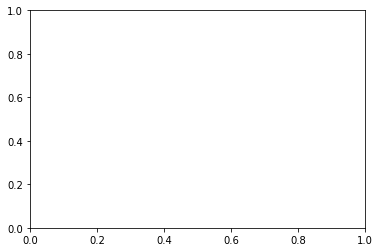

In [44]:
plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

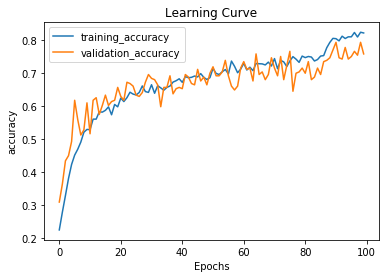

In [13]:

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [46]:
from keras.models import Model, load_model
model1_name = "working"
model1_path = os.path.join(save_dir, model1_name)
model1 = load_model(model1_path)


In [47]:
# Training data

X_tr=[]           # variable to store entire dataset
label=[]

from tqdm import tqdm

ls_path = os.path.join("E:/Jupyter/Project/generated_images512_timeSampled")

for vid_ID in tqdm(validation["Video"].tolist()[0:1500]):
    frames = []
    frame_count=0
    pos_dir = os.path.join(os.path.join(ls_path,"pos"),str(vid_ID))
    neg_dir = os.path.join(os.path.join(ls_path,"pos"),str(vid_ID))
    for img_ID in sorted(os.listdir(pos_dir)):
        if frame_count < nb_frames:
            pos = os.path.join(pos_dir,img_ID)
            neg = os.path.join(neg_dir,img_ID)
            p_img = cv2.imread(pos,0)
            p_img = cv2.resize(p_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
            n_img = cv2.imread(neg,0)
            n_img = cv2.resize(n_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
            frame = cv2.merge((p_img,n_img))
            frames.append(frame)
            frame_count+=1
        else:
            break
    while frame_count < nb_frames:
        frames.append(np.zeros((img_cols,img_rows,channels), np.uint8))
        frame_count+=1
    input_img = np.array(frames)
    ipt=np.rollaxis(np.rollaxis(input_img,2,0),2,0)
    ipt=np.rollaxis(ipt,2,0)
    X_tr.append(ipt)
    label.append(labels_dict[vid_ID])

print (ipt.shape)
num_samples = len(X_tr) 
print (num_samples)
X_tr_array = np.array(X_tr)   # convert the frames read into array

train_data = [X_tr_array,label]
(X_train, y_train) = (train_data[0],train_data[1])
train_set = np.zeros((num_samples, nb_frames, img_cols,img_rows,2))
for h in range(num_samples):
    train_set[h][:][:][:][:]=X_train[h,:,:,:]
Y_train = np_utils.to_categorical(y_train, nb_classes)

100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:07<00:00, 191.33it/s]


(16, 100, 176, 2)
1500


In [48]:
test_pred =model1.predict(train_set[50:70])
result = np.argmax(test_pred, axis =1)
print(result)

[5 3 3 0 5 0 3 3 5 3 0 0 4 2 0 4 4 0 0 2]


In [49]:
img_array = train_set[50]
from sklearn.metrics import confusion_matrix
met = confusion_matrix(np.argmax(Y_train,axis =1), np.argmax(model1.predict(train_set),axis =1))
print(met)

[[244   1   0  18   3   2]
 [  8  29  75  73  25  22]
 [  7  14 108  80  15  37]
 [ 29   0   0 189  24  14]
 [  9   0   0  52 167  17]
 [  3   0   2  55  26 152]]


In [50]:
import itertools
def confusion_matrix_plot(cm, classes, 
                          title='Normalized Confusion Matrix', 
                          normalize=True, 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, range(27), rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

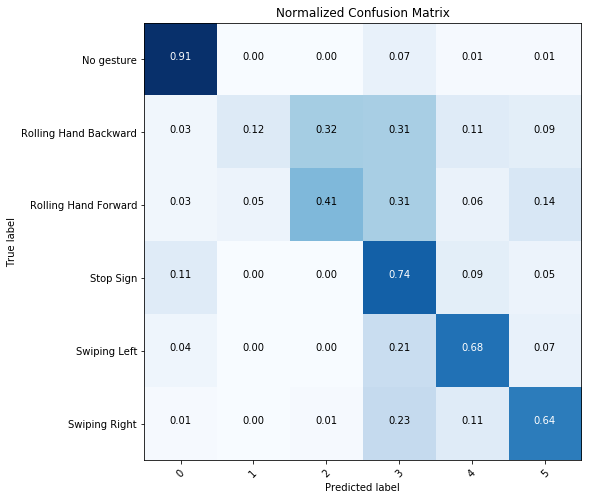

In [51]:
confusion_matrix_plot(met, classes=labels[labels["Class"].isin(["No gesture","Swiping Left","Swiping Right","Stop Sign","Rolling Hand Forward","Rolling Hand Backward"])].sort_values(by=['Label'])['Class'].tolist())

In [52]:
model1.evaluate(train_set,Y_train)

1500/1500 [==============================] - ETA: 13 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 9s 6ms/step


[1.9234457728068033, 0.5926666661898295]